## UC Berkley Homework 3 Part 2 Solution

Based on <b>CS 294-158 Deep Unsupervised Learning</b><br>
Reference Repository: https://github.com/rll/deepul

In [1]:
!if [ -d VAE ]; then rm -Rf VAE; fi
!git clone https://github.com/KayEs141193/VAE.git
!pip install ./VAE
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d tmp/
!rm hw3_data.zip

Cloning into 'VAE'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 96 (delta 47), reused 86 (delta 37), pack-reused 0
Unpacking objects: 100% (96/96), done.
Processing ./VAE
     |████████████████████████████████| 174kB 3.4MB/s 
  Created wheel for VAE: filename=VAE-0.1-cp36-none-any.whl size=6467 sha256=69a4722af769cb542c6b72442aa06e7f930ceae6947dab4ec49208793ba37758
  Stored in directory: /tmp/pip-ephem-wheel-cache-f0zkrb28/wheels/87/c4/92/54bf6a888c3c84c94c915ad1065b66b06a7224aaca6a6e9287
Successfully built VAE
--2020-07-21 11:54:56--  https://docs.google.com/uc?export=download&confirm=sFFQ&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF
Resolving docs.google.com (docs.google.com)... 108.177.112.100, 108.177.112.139, 108.177.112.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.112.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: ht

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import SVHN
import torchvision.transforms as T
from torchvision.utils import make_grid
from IPython.display import display 
import ignite
import pickle
from ignite.engine import Engine, Events
from VAE.models import ConvVAE
from VAE.utils import print_and_collect, plot_results, interpolate_latent
from VAE.trainer import create_basic_trainer, create_basic_evaluator

In [3]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

num_workers = 8 if cuda else 0

In [4]:
def load_pickled_data(fname, include_labels=False):
    with open(fname, 'rb') as f:
        data = pickle.load(f)

    train_data, test_data = data['train'], data['test']
    if 'mnist.pkl' in fname or 'shapes.pkl' in fname:
        # Binarize MNIST and shapes dataset
        train_data = (train_data > 127.5).astype('uint8')
        test_data = (test_data > 127.5).astype('uint8')
    if 'celeb.pkl' in fname:
        train_data = train_data[:, :, :, [2, 1, 0]]
        test_data = test_data[:, :, :, [2, 1, 0]]
    if include_labels:
        return train_data, test_data, data['train_labels'], data['test_labels']
    return train_data, test_data

In [5]:
# Setup Data

batch_size = 128

train_data, test_data = load_pickled_data( './tmp/svhn.pkl')
test_data = 2*(torch.tensor(test_data,device=device,dtype=torch.float).permute(0,3,1,2)/255-0.5)
train_data = 2*(torch.tensor(train_data,dtype=torch.float).permute(0,3,1,2)/255.0-0.5)

train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=num_workers)
#test_loader = DataLoader(2*(torch.tensor(test_data,dtype=torch.float).permute(0,3,1,2)/255.0-0.5),batch_size=batch_size,shuffle=True,num_workers=num_workers)

In [6]:
def convertToImage(x):
  """ Convert 4D tensor to 4D numpy
  """
  return (255*(0.5*torch.clamp(x,-1,1)+0.5)).type(torch.int)

def solution(train_loader,testdata,input_size,base_channel,config_enc,config_dec,latent_dim,lr,epochs):

  train_hist = {'elbo_loss':[],'kl_loss':[],'recon_loss':[]}
  val_hist = {'elbo_loss':[],'kl_loss':[],'recon_loss':[]}

  model = ConvVAE.construct(input_size,base_channel,config_enc, config_dec, latent_dim, device)
  optimizer = optim.Adam(model.parameters(),lr=lr)

  # Setup engines
  evaluator = create_basic_evaluator(model,device)
  trainer = create_basic_trainer(model,optimizer,device)

  # Register handlers
  trainer.add_event_handler(Events.EPOCH_COMPLETED, print_and_collect, evaluator, train_loader, 'Training', train_hist)

  # Run engine
  e = trainer.run(train_loader, max_epochs=epochs)

  genX = convertToImage(model.sample(100).cpu().detach())
  pairs = convertToImage(torch.stack([ a for p in zip(testdata[:50], model(testdata[:50])[0]) for a in p ],dim=0).cpu().detach())
  iters = convertToImage(torch.stack([ vals for i in range(10) for vals in interpolate_latent(testdata[2*i],testdata[2*i+1],model) ], dim =0).cpu().detach())

  return train_hist, val_hist, genX, pairs, iters

In [7]:
input_size = (32,32,3)
latent_dim = 16
base_channel = 128
config_enc = [{'channel':32,'kernel':3,'stride':1},{'channel':64,'kernel':3,'stride':2},{'channel':128,'kernel':3,'stride':2},{'channel':256,'kernel':3,'stride':2}]
config_dec = [{'channel':128,'kernel':4,'stride':2},{'channel':64,'kernel':4,'stride':2},{'channel':32,'kernel':4,'stride':2}]

lr = 0.001
epochs = 30

train_hist, val_hist, genX, pairs, iters = solution(train_loader,test_data,input_size,base_channel,config_enc,config_dec,latent_dim,lr,epochs)

Training Results - Epoch 1 - ELBO loss: 124.11 RECON loss: 115.55 KL loss: 8.56
Training Results - Epoch 2 - ELBO loss: 94.07 RECON loss: 84.68 KL loss: 9.40
Training Results - Epoch 3 - ELBO loss: 83.61 RECON loss: 71.17 KL loss: 12.44
Training Results - Epoch 4 - ELBO loss: 74.43 RECON loss: 61.22 KL loss: 13.20
Training Results - Epoch 5 - ELBO loss: 73.68 RECON loss: 59.74 KL loss: 13.94
Training Results - Epoch 6 - ELBO loss: 68.21 RECON loss: 53.65 KL loss: 14.56
Training Results - Epoch 7 - ELBO loss: 67.28 RECON loss: 52.19 KL loss: 15.10
Training Results - Epoch 8 - ELBO loss: 63.11 RECON loss: 47.10 KL loss: 16.01
Training Results - Epoch 9 - ELBO loss: 61.39 RECON loss: 45.22 KL loss: 16.17
Training Results - Epoch 10 - ELBO loss: 60.32 RECON loss: 44.51 KL loss: 15.81
Training Results - Epoch 11 - ELBO loss: 60.12 RECON loss: 44.12 KL loss: 16.00
Training Results - Epoch 12 - ELBO loss: 59.78 RECON loss: 43.84 KL loss: 15.94
Training Results - Epoch 13 - ELBO loss: 59.13 RE

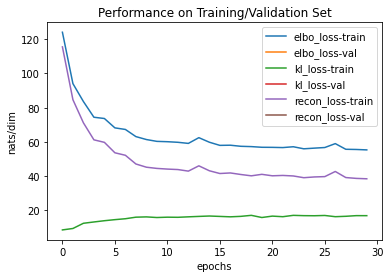

In [8]:
plot_results(train_hist,val_hist)

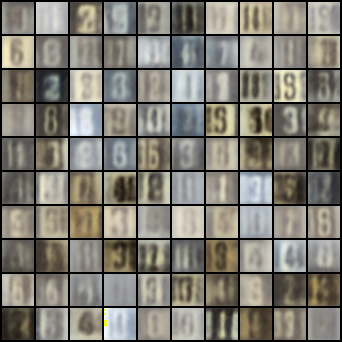

In [9]:
# Generated Samples
display(T.ToPILImage()(make_grid(genX,nrow=10).type(torch.float)))

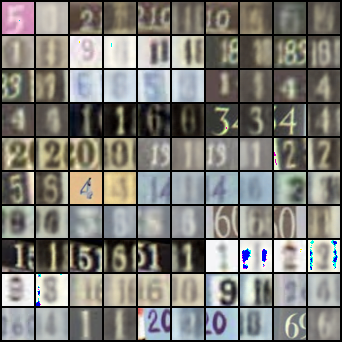

In [10]:
# Pair of Original and Reconstructions
display(T.ToPILImage()(make_grid(pairs,nrow=10).type(torch.float)))

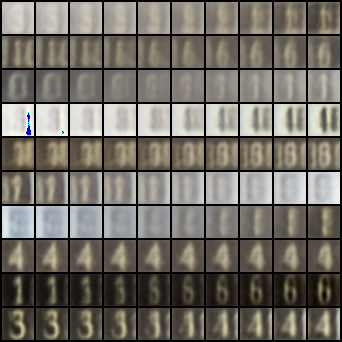

In [11]:
# Interpolations
display(T.ToPILImage()(make_grid(iters,nrow=10).type(torch.float)))